# 'timeit' Function

In [48]:
import time
# Function to help us get the running time
def timeit(func):
    """
    A decorator that times the function func with the arguments that
    are passed to it
    :param func: Function being timed
    :return: func's result
    """
    def clocked(*args, **kwargs):
        t0 = time.perf_counter()
        result = func(*args, **kwargs)
        elapsed = time.perf_counter() - t0
        name = func.__name__
        #print('[%0.8fs] %s' % (elapsed, name))
        return result, elapsed
    return clocked

# Class Graph to allow us to implement graphs 

In [59]:
from typing import TypeVar, List, Dict, Tuple
from math import inf
T = TypeVar("T")

# This class was done in our algorithm class (CS362). We added some modifications
class Graph:
    """
    An undirected Graph with adjacency lists (dictionary)
    """

    def __init__(self):
        """
        Constructor
        """
        self._vertices: Dict[T, List[T]] = { }
        self._edges: List[Tuple[T,T,int]] = [ ]
            

    def add_edge(self, v: T, u: T) -> None:
        """
        Add an edge between v and u to the graph
        """
        if v not in self._vertices:
            self._vertices[v] = []
        if u not in self._vertices:
            self._vertices[u] = []

        self._vertices[v].append(u)
        self._vertices[u].append(v)

    def get_edges(self, v:T):
        """
        Return the list of edges for vertex v 
        """
        return self._vertices[v]
    
    def get_vertices(self) -> List[T]:
        """
        Return the list of the vertices in the graph
        """
        return self._vertices.keys()
    
    def edge_list(self) -> List[Tuple[T,T,int]]:
        """
        Return the list of edges in the graph as a list of tuples. 
        """
        return self._edges
    
    def __str__(self):
        """
        Pretty print the adjacency lists of the graph.
        """
        r = ""
        for u in self.get_vertices():
            r += "{0} --> [".format(u)
            for v in self.get_edges(u):
                r+= "{0}, ".format(v)
            r += '{0}{0}]\n'.format(chr(0x8))
        return r

In [60]:
class WeightedGraph(Graph):

    def __init__(self):
        super().__init__()

    def add_edge(self, v:T, u:T, weight: int):
        if v not in self.get_vertices():
            self._vertices[v] = []
        if u not in self._vertices:
            self._vertices[u] = []
        
        self._edges.append((u,v,weight))
        self._vertices[v].append((u, weight))
        self._vertices[u].append((v, weight))
    

# Boruvka's Algorithm

In [64]:
# Used the same ideas from p.135 of Algorithms by Dasgupta et al.
def find(comp_parents: Dict, v):
    if comp_parents[v] == v:
        return v
    #Go up the component union tree until find parent of component
    return find(comp_parents, comp_parents[v])

#Use union by rank to combine components
def combine(comp_parents, comp_ranks, c1, c2):
    par1 = find(comp_parents, c1)
    par2 = find(comp_parents, c2)
    
    if comp_ranks[par1] == comp_ranks[par2]:
        comp_parents[par2] = par1
        comp_ranks[par1] += 1
    else:
        if comp_ranks[par1] < comp_ranks[par2]:
            comp_parents[par1] = par2

        else:
            comp_parents[par2] = par1 
@timeit   
def boruvka(g: Graph) -> Graph: #|E|Log(|V|)
    comp_parents = {} #dict for parent of each component
    comp_ranks = {} #rank of each component for component union by rank
    smallest_edge = {} #dictionary to store the smallest edge of each component
    c_num = len(g.get_vertices()) #number of components 
    tot_weight = 0 # the total weight of the MST
    edges = g.edge_list()
    vertices = g.get_vertices()
    
    #create component for each vertex
    for v in vertices:
        comp_parents[v] = v
        comp_ranks[v] = v
        smallest_edge[v] = None 
        
    #combine components until we have one component
    while c_num != 1:
        
        
        #go through the edges
        for e in edges:

            u,v,w = e
            
            #get component of u and component of v (gets the root node of union tree)
            c1 = find(comp_parents, u)
            c2 = find(comp_parents, v)
           
             
            #if the vertices are not in the same component
            if c1 != c2 : 
                
                #get the smallest edge of each component
                if smallest_edge[c1] == None or w < smallest_edge[c1][2]:
                    smallest_edge[c1] = [u,v,w]
                if smallest_edge[c2] == None or w < smallest_edge[c2][2]:
                    smallest_edge[c2] = [u,v,w]
                    
                    
        
        #add the new smallest edges of components to the MST
        for vert in vertices:
            
            #if the vertex has the smallest edge, get the edge from the vertex
            if smallest_edge[vert] != None:
                u,v,w = smallest_edge[vert]
                
                #get the components of u and v
                c1 = find(comp_parents, u)
                c2 = find(comp_parents, v)
                
                #if the components arent already connected, connect them 
                if c1 != c2:
                    combine(comp_parents, comp_ranks, c1, c2)
                    tot_weight += w
                    c_num -= 1
                    
        #reset the min edges
        for v in vertices:
            smallest_edge[v] = None 
    
    return(tot_weight)

g = WeightedGraph()
g.add_edge('a', 'b', 6)
g.add_edge('a', 'c', 2)
g.add_edge('a', 'd', 4)
g.add_edge('b', 'd', 7)
g.add_edge('c', 'd', 1)
g.add_edge('e', 'a', 11)
g.add_edge('e', 'b', 3)

print(boruvka(g)[0])


12


In [62]:
g = WeightedGraph()
g.add_edge('a', 'b', 6)
g.add_edge('a', 'c', 2)
g.add_edge('a', 'd', 4)
g.add_edge('b', 'd', 7)
g.add_edge('c', 'd', 1)
g.add_edge('e', 'a', 11)
g.add_edge('e', 'b', 3)

print(g.edge_list())

[('b', 'a', 6), ('c', 'a', 2), ('d', 'a', 4), ('d', 'b', 7), ('d', 'c', 1), ('a', 'e', 11), ('b', 'e', 3)]


# Running the algorithm on different graphs with different sizes

In [67]:
import random

ts_boruvka = [] # list of times 
# Create 49 different graphs starting with 10 vertices up to 490 vertices(they are all complete graphs)
for n in range(10, 500, 10):
    g = WeightedGraph()
    for i in range (n):
        for j in range(i+1,n):
            g.add_edge(i,j,random.randrange(1,21))
    (x, t) = boruvka(g)
    ts_boruvka.append(t)
print(ts_boruvka)

[0.00013336400297703221, 0.0005075579974800348, 0.0017610040013096295, 0.007467589995940216, 0.015118251001695171, 0.017585433000931516, 0.009123821000684984, 0.04860537999775261, 0.028113124004448764, 0.035904477001167834, 0.029296891996636987, 0.044636963997618295, 0.05637726900022244, 0.05106894500204362, 0.04589113000110956, 0.10037790299975313, 0.12892973300040467, 0.07036400200013304, 0.09771010400436353, 0.2576635000004899, 0.11430561599991051, 0.2551077320022159, 0.2746793539990904, 0.14038738700037356, 0.17400926299887942, 0.21602620300109265, 0.19991161600046325, 0.2097567960008746, 0.27034690599975875, 0.25519593599892687, 1.083955412999785, 0.29484038700320525, 0.5223629200045252, 0.5753151450044243, 0.4507335160014918, 0.47514081299596, 0.7603729229958844, 0.882812678006303, 1.1763498420041287, 1.1362550230041961, 0.9167303150024964, 2.7150210429972503, 0.8966199439964839, 0.9741878909990191, 1.0477083079967997, 1.5407343760016374, 1.4918065000019851, 1.160891184998036, 1.

# Boruvka's Algorithm Running Time

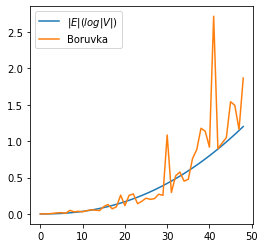

In [70]:
import numpy as np
import math
import matplotlib.pyplot as plt
fig = plt.figure("Class Demo", figsize=(4,4))
# We devide it by 2500 because of the constants.(it's to better scale it to the points we got through running the program)
g = [(math.log(x,2)*(x*(x-1)/2))/5500 for x in range(1,50) ]
ax = fig.add_subplot(111)
ax.plot(g, label=r"$|E|(log |V|)$")
ax.plot(ts_boruvka, label="Boruvka")
ax.legend()